In [1]:
import glob
import numpy as np
import pandas as pd

import clima_anom as ca

import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs

### Used Variables Description
- NPIXELS_XXDBZ: Number of pixels with XX dbz - (20, 30, 40 and 50)
- NPIXELS_XXMM : Number of tmi rain pixels - (20, 30, 40 and 50)
- VOLRAIN_XXDBZ: Volumetric rainfall from area with 20 dBZ (km^2 mm/hr) - (20, 30, 40 and 50)
- VOLRAIN_XXMM: volumetric rain from 2A.PR (km^2 mm/hr) - (20, 30, 40 and 50)
- MINXXPCT: Minimum XX GHz polarization correction TB (K) - (85 and 37)
- NLTXXX: Number of PR pixels with 85 GHz PCT < XXX K (#) - (250 and 225)
- N37LTXXX: Number of pixels with 37 GHz PCT < XXXK (#) - (250 and 225)
- MAXHTXX: Maximum height reached by the feature with XX dBZ (km) - (20, 30 and 40)
- NSTRAT_2A25/NCONV_2A25: Number of pixels with stratiform/convective rainfall (#)
- RAINSTRAT_2A25/RAINCONV_2A25: Stratiform/Convective volumetric rain (mm/hr*km^2)
- MAXNSRAIN: Maximum 2A.PR nearsurface rainfall rate (mm/hr) - TRMM
- MAXNSPRECIP:Maximum near surface precip rate (mm/hr) - GPM

In [2]:
# satellite = 'TRMM'
satellite = 'GPM'

In [3]:
if satellite == 'TRMM':
    product = 'rpf'
    dir_input = '/mnt/Data/Data/PF/TRMM/rpf/*.HDF'
    out_input = '/mnt/Data/Data/PF/TRMM/rpf_SA/'

    list_var = ['YEAR','ORBIT',
                'NPIXELS_20DBZ', 'NPIXELS_30DBZ','NPIXELS_40DBZ',
                'NPIXELS_20MM', 'NPIXELS_30MM', 'NPIXELS_40MM',
                'VOLRAIN_20DBZ', 'VOLRAIN_30DBZ', 'VOLRAIN_40DBZ',
                'MAXNSRAIN',
                'MIN85PCT', 'MIN37PCT',
                'NLT250','NLT225',
                'N37LT250','N37LT225',
                'MAXHT20','MAXHT30','MAXHT40',
                'NSTRAT_2A25', 'RAINSTRAT_2A25',
                'NCONV_2A25', 'RAINCONV_2A25']

elif satellite == 'GPM':
    product = 'rgpf'
    dir_input = '/mnt/Data/Data/PF/GPM/rgpf/*.HDF'
    out_input = '/mnt/Data/Data/PF/GPM/rgpf_SA/'

    list_var = ['YEAR','ORBIT',
                'NPIXELS_20DBZ', 'NPIXELS_30DBZ','NPIXELS_40DBZ',
                'NPIXELS_20MM', 'NPIXELS_30MM', 'NPIXELS_40MM',
                'VOLRAIN_20DBZ', 'VOLRAIN_30DBZ', 'VOLRAIN_40DBZ',
                'MAXNSPRECIP',
                'MIN85PCT', 'MIN37PCT',
                'NLT250','NLT225',
                'N37LT250','N37LT225',
                'MAXHT20','MAXHT30','MAXHT40',
                'NSTRAT_KU','RAINSTRAT_KU',
                'NCONV_KU','RAINCONV_KU']

else:
    raise ValueError('Invalid satellite')

print(f'Satellite: {satellite}')
print(f'Product  : {product}')
print(f'Directory: {dir_input}')

Satellite: GPM
Product  : rgpf
Directory: /mnt/Data/Data/PF/GPM/rgpf/*.HDF


In [4]:
list_files = glob.glob(dir_input)
list_files = sorted(list_files)
len_files = len(list_files)
print(f'{len_files} files found')
list_files[0:2]

84 files found


['/mnt/Data/Data/PF/GPM/rgpf/pf_201403_level2.HDF',
 '/mnt/Data/Data/PF/GPM/rgpf/pf_201404_level2.HDF']

In [5]:
# data = ca.read_netcdf(list_files[0],2)

In [6]:
levels_reflec = np.arange(0.5, 20.5, 0.5)

for nn in range(len_files):

    file_input = list_files[nn]
    print(file_input)

    data = ca.read_netcdf(file_input,0)
    lat = data['LAT'].data
    lon = data['LON'].data

    data_in = np.zeros([len(lat),len(list_var)])

    for t in range(len(list_var)):
        data_in[:,t] = np.round(data[list_var[t]].data,2)

    pd_in = pd.DataFrame(data_in, columns=list_var)
    pd_in.insert(0, "lat", lat, True)
    pd_in.insert(1, "lon", lon, True)

    data_RL = data['MAXDBZ'].data
    if satellite == 'TRMM':
        data_RL = data_RL*0.01
    data_RL[data_RL < 0] = np.nan
    RL_dict = pd.DataFrame(data_RL, columns=levels_reflec)

    result = pd.concat([pd_in, RL_dict], axis=1)

    # South America Region
    out1 = result[(result['lon'] >= -85) & (result['lon'] <= -30 )]
    out2 = out1[(out1['lat'] >= -45) & (out1['lat'] <= 15 )]

    if satellite == 'TRMM':
        out2=out2.rename(columns = {'NSTRAT_2A25':'NSTRAT'})
        out2=out2.rename(columns = {'RAINSTRAT_2A25':'RAINSTRAT'})
        out2=out2.rename(columns = {'NCONV_2A25':'NCONV'})
        out2=out2.rename(columns = {'RAINCONV_2A25':'RAINCONV'})

    elif satellite == 'GPM':
        out2=out2.rename(columns = {'MAXNSPRECIP':'MAXNSRAIN'})
        out2=out2.rename(columns = {'NSTRAT_KU':'NSTRAT'})
        out2=out2.rename(columns = {'RAINSTRAT_KU':'RAINSTRAT'})
        out2=out2.rename(columns = {'NCONV_KU':'NCONV'})
        out2=out2.rename(columns = {'RAINCONV_KU':'RAINCONV'})

    else:
        raise ValueError('Invalid satellite')

    # export dataframe to csv
    salida = out_input + file_input.split('/')[-1].replace('.HDF','.csv').replace('pf',product)
    print(f'Exporting data to {salida}')
    out2.to_csv(salida,header=True,index=False)

    print()

/mnt/Data/Data/PF/GPM/rgpf/pf_201403_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201403_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201404_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201404_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201405_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201405_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201406_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201406_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201407_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201407_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201408_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201408_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201409_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201409_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201410_level2.HDF
Exporting data to /mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_201410_level2.csv

/mnt/Data/Data/PF/GPM/rgpf/pf_201411_lev

In [7]:
# for nn in range(len_files):

#     file_input = list_files[nn]
#     print(file_input)

#     data = ca.read_netcdf(file_input,0)
#     lat = data['LAT'].data
#     lon = data['LON'].data

#     data_in = np.zeros([len(lat),len(list_var)])

#     for t in range(len(list_var)):
#         data_in[:,t] = np.round(data[list_var[t]].data,2)

#     pd_in = pd.DataFrame(data_in, columns=list_var)
#     pd_in.insert(0, "lat", lat, True)
#     pd_in.insert(1, "lon", lon, True)

#     # South America Region
#     out1 = pd_in[(pd_in['lon'] >= -85) & (pd_in['lon'] <= -30 )]
#     out2 = out1[(out1['lat'] >= -45) & (out1['lat'] <= 15 )]

#     if satellite == 'TRMM':
#         out2=out2.rename(columns = {'NSTRAT_2A25':'NSTRAT'})
#         out2=out2.rename(columns = {'RAINSTRAT_2A25':'RAINSTRAT'})
#         out2=out2.rename(columns = {'NCONV_2A25':'NCONV'})
#         out2=out2.rename(columns = {'RAINCONV_2A25':'RAINCONV'})

#     elif satellite == 'GPM':
#         out2=out2.rename(columns = {'NSTRAT_KU':'NSTRAT'})
#         out2=out2.rename(columns = {'RAINSTRAT_KU':'RAINSTRAT'})
#         out2=out2.rename(columns = {'NCONV_KU':'NCONV'})
#         out2=out2.rename(columns = {'RAINCONV_KU':'RAINCONV'})

#     else:
#         raise ValueError('Invalid satellite')

#     # export dataframe to csv
#     salida = out_input + file_input.split('/')[-1].replace('.HDF','.csv').replace('pf',product)
#     print(f'Exporting data to {salida}')
#     out2.to_csv(salida,header=True,index=False)

#     print()

In [8]:
out2

,lat,lon,YEAR,ORBIT,NPIXELS_20DBZ,NPIXELS_30DBZ,NPIXELS_40DBZ,NPIXELS_20MM,NPIXELS_30MM,NPIXELS_40MM,...,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0
102,-44.619934,-84.760170,2021.0,39364.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,-44.464607,-84.960648,2021.0,39364.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,-44.376434,-83.419342,2021.0,39364.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,-44.017048,-83.168907,2021.0,39364.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,-43.805801,-83.054039,2021.0,39364.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589607,13.845942,-71.477127,2021.0,39795.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589608,14.455017,-72.425964,2021.0,39795.0,5.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589609,14.396589,-72.042496,2021.0,39795.0,12.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589610,14.537724,-72.597115,2021.0,39795.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


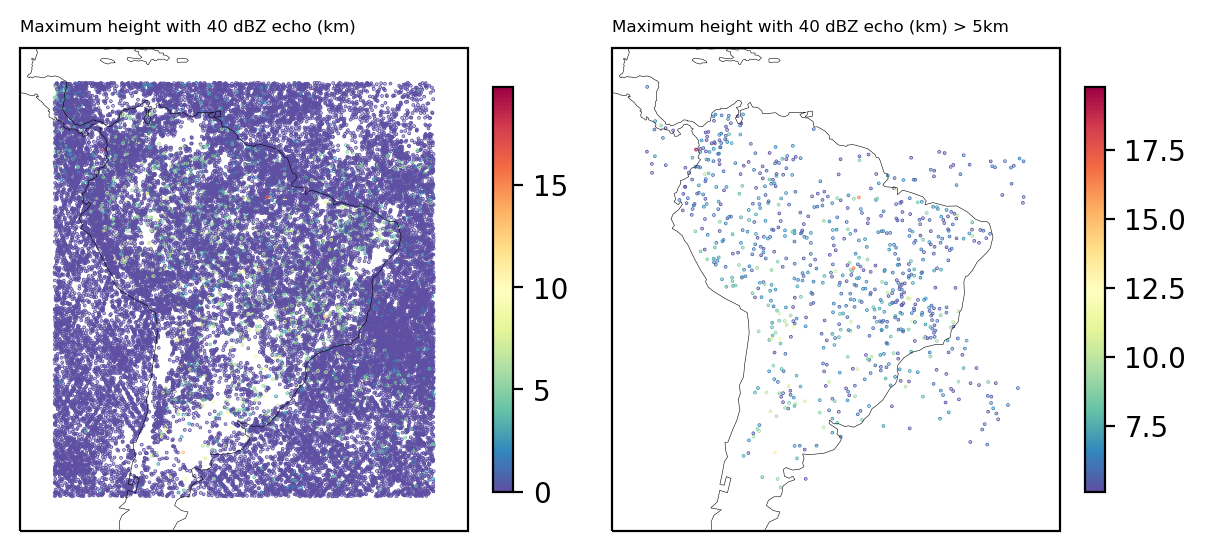

In [9]:
alt_ref = 5

proj = ccrs.PlateCarree()
cmap = plt.cm.Spectral_r

fig = plt.figure(figsize=(7,4),dpi=200)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.2,color='black',zorder=4)
ax1.set_extent([-90,-25,-50,20],crs=proj)
a1 = ax1.scatter(out2['lon'],out2['lat'],c=out2['MAXHT40'],cmap=cmap,s=0.1,zorder=3)
ax1.set_title('Maximum height with 40 dBZ echo (km)',fontsize=6,loc='left')
plt.colorbar(a1,fraction=0.041)

ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.2,color='black',zorder=4)
ax1.set_extent([-90,-25,-50,20],crs=proj)
a1 = ax1.scatter(out2['lon'][out2['MAXHT40']>alt_ref],out2['lat'][out2['MAXHT40']>alt_ref],c=out2['MAXHT40'][out2['MAXHT40']>alt_ref],cmap=cmap,s=0.1,zorder=3)
ax1.set_title('Maximum height with 40 dBZ echo (km) > '+str(alt_ref)+'km',fontsize=6,loc='left')
plt.colorbar(a1,fraction=0.041)